## Human in the loop

In [1]:
# Another way to initialize model
from langchain.chat_models import init_chat_model

llm = init_chat_model(model="llama3.2:latest", model_provider="ollama")

d:\Studies\Programming\LangChain\venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
d:\Studies\Programming\LangChain\venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


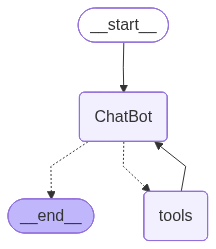

In [ ]:
from typing import TypedDict, Annotated

from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from IPython.display import Image  # Added import

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request Assistant from human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

search_tool = TavilySearch(max_results=2)  

# Tool binding
tools = [search_tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)  

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])  
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume
    return {"messages": [message]}

graph_builder.add_node("ChatBot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "ChatBot",  
    tools_condition,
)

graph_builder.add_edge(START, "ChatBot")
graph_builder.add_edge("tools", "ChatBot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (292cf0d5-2dc7-406b-8188-27cc88fccb12)
 Call ID: 292cf0d5-2dc7-406b-8188-27cc88fccb12
  Args:
    query: Request Assistant from human.
================================== Ai Message ==================================
Tool Calls:
  human_assistance (292cf0d5-2dc7-406b-8188-27cc88fccb12)
 Call ID: 292cf0d5-2dc7-406b-8188-27cc88fccb12
  Args:
    query: Request Assistant from human.


In [4]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (292cf0d5-2dc7-406b-8188-27cc88fccb12)
 Call ID: 292cf0d5-2dc7-406b-8188-27cc88fccb12
  Args:
    query: Request Assistant from human.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

It seems like you're looking for a more robust solution for building an AI agent. LangGraph is indeed a popular choice among developers, offering a flexible and scalable framework for creating intelligent systems.

To get started with LangGraph, I'd suggest checking out their official documentation and tutorials. They provide a comprehensive guide on how to set up the framework, create agents, and i